[View in Colaboratory](https://colab.research.google.com/github/rafaelszp/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb)

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#!git clone https://github.com/rafaelszp/dlnd_face_generation.git
#!cp dlnd_face_generation/*.py .
#!pip install -U matplotlib==2.0.2
#!pip install tqdm

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

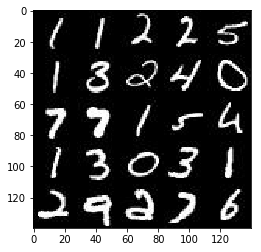

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

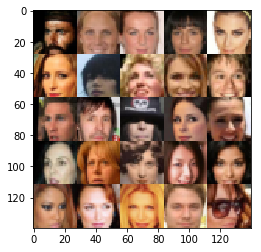

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim),name='noise')
    l = tf.placeholder(tf.float32,name='learning_rate')

    return x, z, l



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [7]:

leakyRelu = lambda x,alpha=0.2: tf.maximum(x*alpha,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #kernel_init = tf.random_normal_initializer(stddev=0.02)
    kernel_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    def conv(images, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_first=False):
      x = tf.layers.conv2d(images, n_filters, kernel_size, strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_first):
        x = tf.layers.batch_normalization(x, training=True)
      x = leakyRelu(x)
      if(not is_first):
          x = tf.nn.dropout(x,keep_prob=0.9)

      return x
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = conv(images,64,is_first=True)
        # 14x14x64        
        x = conv(x,128)
        # 7x7x128
        x = conv(x,256)
        # 4x4x256
        
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def deconv(inputs, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_last=False):
      x = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_last):
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)
        

      return x
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)        
        
        # 7x7x256
        x = deconv(x,128)
        # 14x14x128
        x = deconv(x,64)
        # 28x28x64
        x = tf.nn.dropout(x,keep_prob=0.9)
        
        
        logits = deconv(x,n_filters=out_channel_dim,kernel_size=3,strides=1,is_last=True)
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
            
    gmodel = generator(input_z,out_channel_dim,is_train=True)
    dmodel, dmodel_logits = discriminator(input_real,reuse=False) 
    gxdmodel, gxdmodel_logits = discriminator(gmodel,reuse=True)
    
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dmodel_logits,labels=tf.ones_like(dmodel)))
    gxdloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.zeros_like(gxdmodel)))
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.ones_like(gxdmodel)))
    
    dloss = dloss + gxdloss
    
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [19]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(x.max() - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, noisez, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    dloss,gloss = model_loss(images,noisez,data_shape[3])
    d_train_opt,g_train_opt = model_opt(dloss,gloss,learning_rate,beta1)
    iterations = 0
    
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                batch_images = scale(batch_images*2.0)
                iterations +=1
                batch_noisez = np.random.uniform(-1,1,size=(batch_size,z_dim))
                dict_d = {
                  images: batch_images,
                  noisez: batch_noisez
                }
                dict_g = {
                    noisez: batch_noisez,
                    images: batch_images,
                }
                _ = sess.run(d_train_opt,feed_dict=dict_d)
                _ = sess.run(g_train_opt,feed_dict=dict_g)
                #calculating loss for the blablablablablalbla
                if(iterations % 10==0):
                  train_loss_d = dloss.eval({images:batch_images,noisez:batch_noisez})
                  train_loss_g = gloss.eval({noisez: batch_noisez})
                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                  
                if iterations % 100 == 0:
                    print("iteration",iterations)
                    show_generator_output(sess, 25, noisez, data_shape[3], data_image_mode)
        secs_duration = (time.time() - start_time)
        mins_duration = secs_duration/60
        
        print('Training done seconds: {}. Time in minutes: {}. Iterations: {}'.format(secs_duration,mins_duration,iterations))
                
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting...
Epoch 1/2... Discriminator Loss: 6.0375... Generator Loss: 0.0131
Epoch 1/2... Discriminator Loss: 2.7778... Generator Loss: 0.0919
Epoch 1/2... Discriminator Loss: 2.3058... Generator Loss: 0.1774
Epoch 1/2... Discriminator Loss: 2.3168... Generator Loss: 0.1333
Epoch 1/2... Discriminator Loss: 1.9220... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 1.7083... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 0.3618
Epoch 1/2... Discriminator Loss: 1.7313... Generator Loss: 0.3053
Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.8781
iteration 100


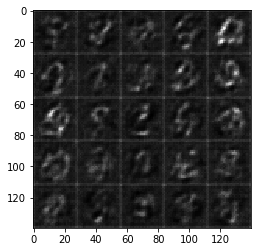

Epoch 1/2... Discriminator Loss: 1.6789... Generator Loss: 0.2297
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 1.3132
Epoch 1/2... Discriminator Loss: 2.2335... Generator Loss: 0.1463
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.3915
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.6803... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.7019... Generator Loss: 0.2578
iteration 200


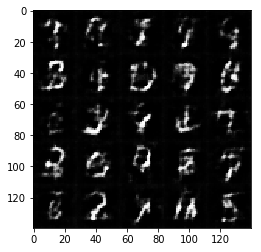

Epoch 1/2... Discriminator Loss: 2.1882... Generator Loss: 0.1664
Epoch 1/2... Discriminator Loss: 1.7402... Generator Loss: 0.2554
Epoch 1/2... Discriminator Loss: 2.0728... Generator Loss: 0.1900
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.2660
Epoch 1/2... Discriminator Loss: 1.8916... Generator Loss: 0.2528
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.9930
Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.5630
iteration 300


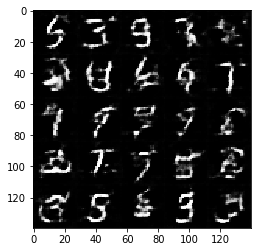

Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.5533... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 2.0088... Generator Loss: 0.2394
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.2912
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.3566
iteration 400


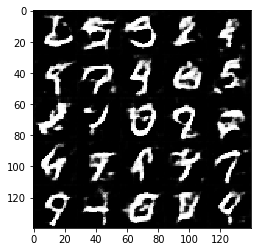

Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.2985
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.2929
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 0.2964
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.6056
iteration 500


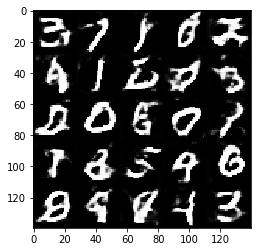

Epoch 1/2... Discriminator Loss: 2.0048... Generator Loss: 0.2258
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.2915
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.8916
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.4633
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.2643
iteration 600


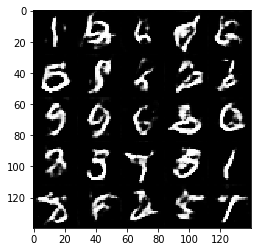

Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 1.7161
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 2.9059... Generator Loss: 0.0996
iteration 700


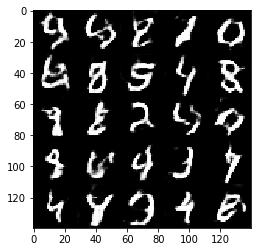

Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.9236... Generator Loss: 2.3423
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.4886
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 0.8815
iteration 800


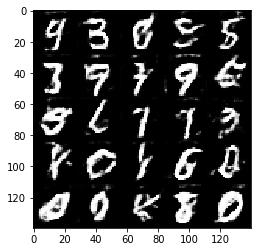

Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 0.9711
Epoch 1/2... Discriminator Loss: 2.2893... Generator Loss: 0.1223
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 3.1739... Generator Loss: 3.7984
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 0.8446
iteration 900


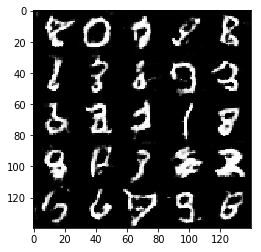

Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 0.2878
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.6483
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 1.2687
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 0.7726... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.8637
iteration 1000


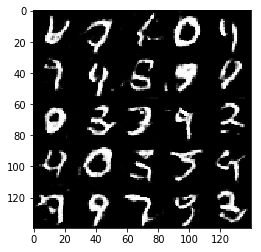

Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.9505
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.5558
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 1.9332
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 1.7947
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.5598
iteration 1100


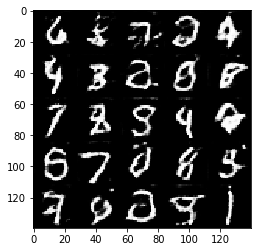

Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.6668
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 1.6953
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 1.2238
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 2.9643
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.8992
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.5798
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.4696
iteration 1200


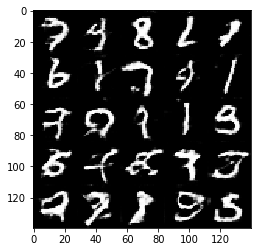

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 1.3696
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 2.1556
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.3309
Epoch 1/2... Discriminator Loss: 0.6596... Generator Loss: 1.1690
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 1.7670
iteration 1300


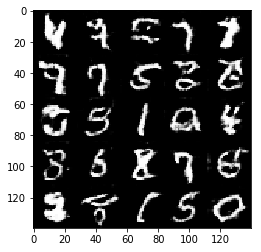

Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.2973
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 2.0454
iteration 1400


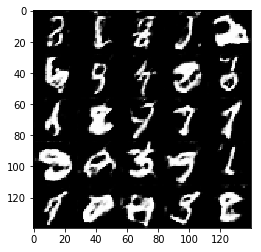

Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 2.1604
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 2.8483
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.4426
Epoch 1/2... Discriminator Loss: 0.4883... Generator Loss: 1.4422
Epoch 1/2... Discriminator Loss: 0.5742... Generator Loss: 1.6900
iteration 1500


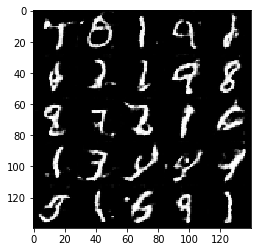

Epoch 1/2... Discriminator Loss: 2.2129... Generator Loss: 4.0076
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.1726
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 1.7612
Epoch 1/2... Discriminator Loss: 0.4474... Generator Loss: 2.0433
Epoch 1/2... Discriminator Loss: 1.5381... Generator Loss: 0.3183
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 0.7387... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 0.7049
iteration 1600


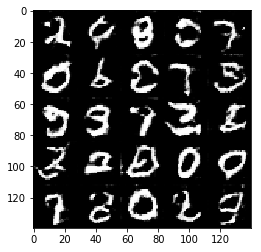

Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 2.5165
Epoch 1/2... Discriminator Loss: 2.1932... Generator Loss: 0.2969
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 0.6212
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 1.5063
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.1392
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.5735
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.5109
Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.2687
iteration 1700


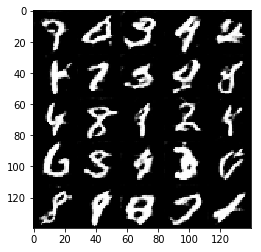

Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 1.8873
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 2.0884
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 0.3004... Generator Loss: 2.1396
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.0164
iteration 1800


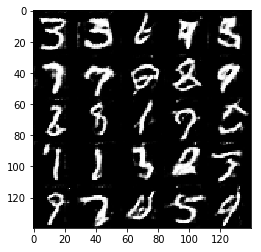

Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 1.6524
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 2.3216
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.3950
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 0.4788... Generator Loss: 1.6983
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.0966
iteration 1900


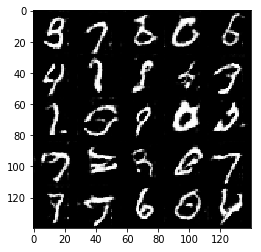

Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.4739
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.1348
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 1.8793
Epoch 2/2... Discriminator Loss: 0.4452... Generator Loss: 1.6342
Epoch 2/2... Discriminator Loss: 1.7859... Generator Loss: 3.8307
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 2.1895
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 0.4386... Generator Loss: 1.4563
iteration 2000


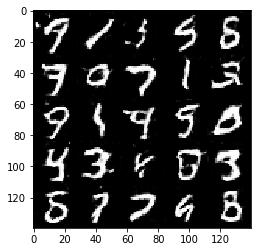

Epoch 2/2... Discriminator Loss: 0.5129... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 1.6386
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 0.2684... Generator Loss: 2.2074
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.1645
iteration 2100


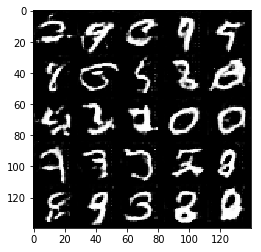

Epoch 2/2... Discriminator Loss: 1.6477... Generator Loss: 3.6385
Epoch 2/2... Discriminator Loss: 0.5617... Generator Loss: 1.4132
Epoch 2/2... Discriminator Loss: 0.6483... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 0.4666... Generator Loss: 1.8928
Epoch 2/2... Discriminator Loss: 0.3859... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 0.2953... Generator Loss: 1.9591
Epoch 2/2... Discriminator Loss: 2.1308... Generator Loss: 0.2366
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.6272
iteration 2200


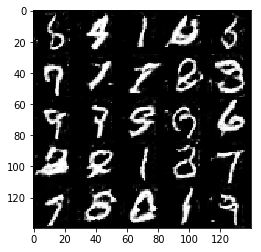

Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.3963
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.6355
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 1.4699
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.4712
Epoch 2/2... Discriminator Loss: 0.3161... Generator Loss: 2.3536
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 1.8047
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 1.6678
iteration 2300


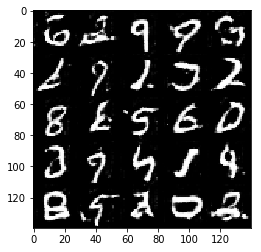

Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 1.2909
Epoch 2/2... Discriminator Loss: 0.3712... Generator Loss: 2.2143
Epoch 2/2... Discriminator Loss: 0.3095... Generator Loss: 2.5285
Epoch 2/2... Discriminator Loss: 0.3319... Generator Loss: 2.0976
Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 2.1487
Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 1.8575
Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 1.4460
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.3662
Epoch 2/2... Discriminator Loss: 4.9554... Generator Loss: 0.0202
Epoch 2/2... Discriminator Loss: 1.8089... Generator Loss: 0.3038
iteration 2400


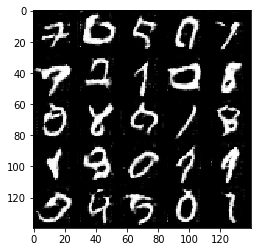

Epoch 2/2... Discriminator Loss: 2.4477... Generator Loss: 0.1142
Epoch 2/2... Discriminator Loss: 0.5185... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: 0.2772... Generator Loss: 2.3478
Epoch 2/2... Discriminator Loss: 0.4130... Generator Loss: 1.8484
Epoch 2/2... Discriminator Loss: 0.3061... Generator Loss: 2.2382
Epoch 2/2... Discriminator Loss: 0.3526... Generator Loss: 2.2629
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 0.4676... Generator Loss: 1.3673
iteration 2500


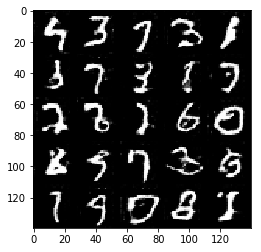

Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.6796
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.3867... Generator Loss: 1.5309
Epoch 2/2... Discriminator Loss: 0.5381... Generator Loss: 1.8421
Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.2354... Generator Loss: 2.6653
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.5339
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.6709
iteration 2600


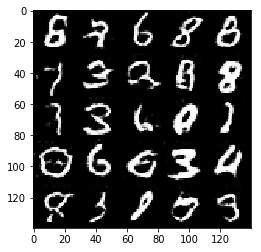

Epoch 2/2... Discriminator Loss: 0.4421... Generator Loss: 1.4958
Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 1.9869
Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 1.5628
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 1.6822
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 2.2353
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.0842
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.8650
iteration 2700


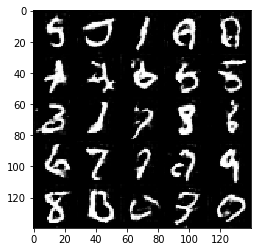

Epoch 2/2... Discriminator Loss: 1.5870... Generator Loss: 0.3394
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 0.3833... Generator Loss: 1.6903
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 0.2884... Generator Loss: 2.2231
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.9793
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.6599
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.2494
iteration 2800


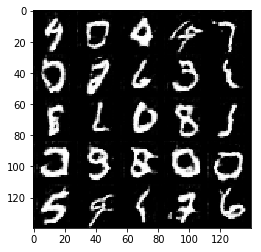

Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 2.8001
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 0.2141... Generator Loss: 2.0536
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 1.3013
Epoch 2/2... Discriminator Loss: 1.7587... Generator Loss: 4.6171
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 0.4774... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 1.6147... Generator Loss: 4.3912
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 0.5601
iteration 2900


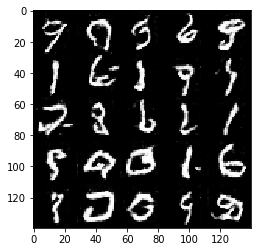

Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 0.4806... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 3.8642
Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 2.1800
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 1.6611
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 1.9532
iteration 3000


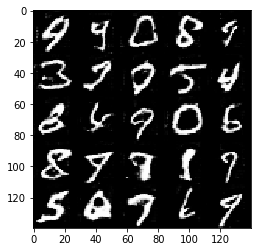

Epoch 2/2... Discriminator Loss: 0.4986... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 0.2941... Generator Loss: 3.7370
Epoch 2/2... Discriminator Loss: 0.4862... Generator Loss: 2.1427
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 2.8019
Epoch 2/2... Discriminator Loss: 0.3506... Generator Loss: 1.7060
Epoch 2/2... Discriminator Loss: 0.3141... Generator Loss: 2.4180
Epoch 2/2... Discriminator Loss: 1.8613... Generator Loss: 5.6822
iteration 3100


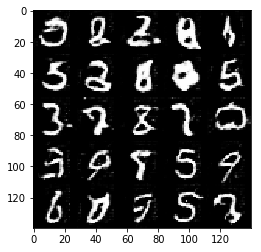

Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 5.0446
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 2.9018
Epoch 2/2... Discriminator Loss: 0.5549... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.3853... Generator Loss: 2.2226
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 1.9602
Epoch 2/2... Discriminator Loss: 0.4400... Generator Loss: 1.8624
Epoch 2/2... Discriminator Loss: 0.2449... Generator Loss: 2.3045
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 1.4898
Epoch 2/2... Discriminator Loss: 0.2723... Generator Loss: 2.2381
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 1.5969
iteration 3200


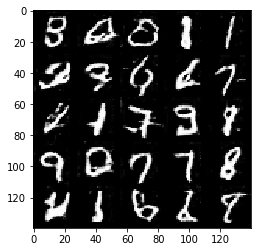

Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 0.2617... Generator Loss: 2.0411
Epoch 2/2... Discriminator Loss: 0.2282... Generator Loss: 2.5260
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 1.5508
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 0.3434... Generator Loss: 2.1090
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 3.7936
iteration 3300


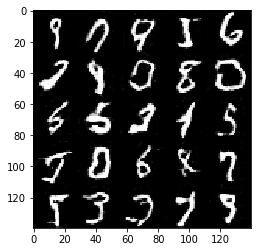

Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.5023
Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 2.1037
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.1143... Generator Loss: 3.1291
Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 1.3621
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 1.8432
Epoch 2/2... Discriminator Loss: 4.6872... Generator Loss: 8.0506
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 0.4004... Generator Loss: 1.8936
iteration 3400


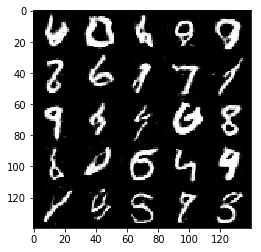

Epoch 2/2... Discriminator Loss: 0.3127... Generator Loss: 2.5959
Epoch 2/2... Discriminator Loss: 0.2512... Generator Loss: 2.7153
Epoch 2/2... Discriminator Loss: 0.3193... Generator Loss: 3.0414
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 2.0791
Epoch 2/2... Discriminator Loss: 0.2006... Generator Loss: 2.5200
Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 2.2419
Epoch 2/2... Discriminator Loss: 0.5623... Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 2.3061... Generator Loss: 5.4577
iteration 3500


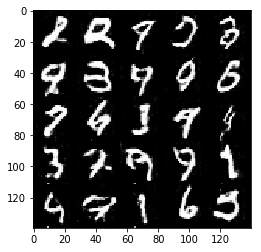

Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.3108
Epoch 2/2... Discriminator Loss: 0.1709... Generator Loss: 3.6215
Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 1.5571
Epoch 2/2... Discriminator Loss: 0.2609... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.1730... Generator Loss: 2.5366
Epoch 2/2... Discriminator Loss: 0.2990... Generator Loss: 1.8787
Epoch 2/2... Discriminator Loss: 0.1934... Generator Loss: 2.9275
Epoch 2/2... Discriminator Loss: 0.4318... Generator Loss: 2.0977
Epoch 2/2... Discriminator Loss: 0.2676... Generator Loss: 2.1986
Epoch 2/2... Discriminator Loss: 0.0991... Generator Loss: 3.8489
iteration 3600


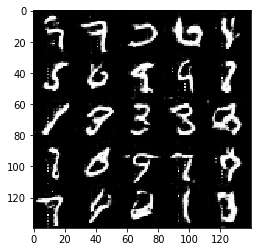

Epoch 2/2... Discriminator Loss: 0.3111... Generator Loss: 2.3531
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.9579
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 3.9299
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 3.6417
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 1.7153
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 1.3962
Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 2.0826
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 0.4087... Generator Loss: 2.1102
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.3161
iteration 3700


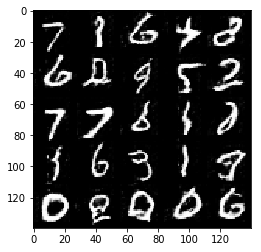

Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 2.6132
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.7202
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.3395
Training done seconds: 264.239483833313. Time in minutes: 4.403991397221883


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3
print('Starting...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.8457
iteration 100


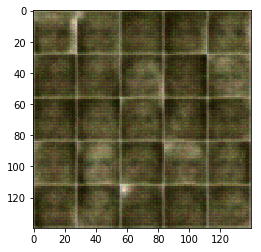

Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 2.0600
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7818
iteration 200


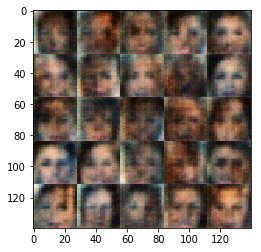

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8561
iteration 300


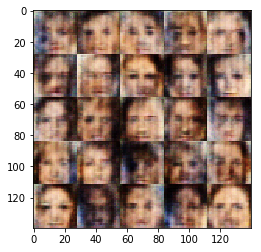

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7623
iteration 400


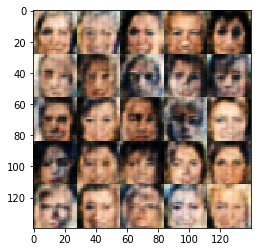

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7214
iteration 500


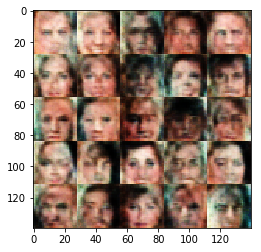

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7468
iteration 600


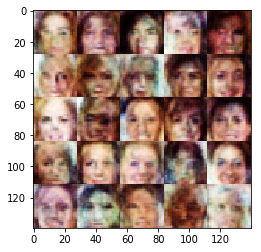

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7350
iteration 700


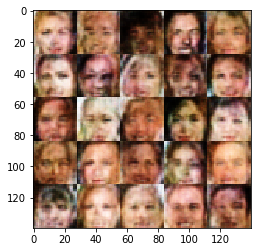

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7322
iteration 800


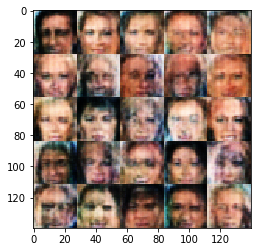

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7399
iteration 900


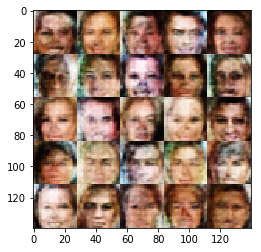

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7533
iteration 1000


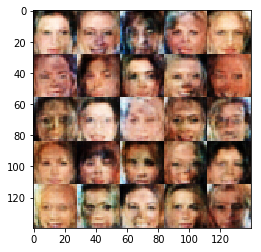

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6978
iteration 1100


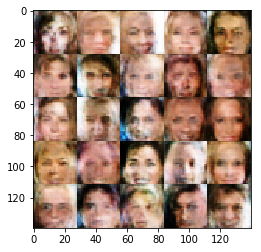

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7946
iteration 1200


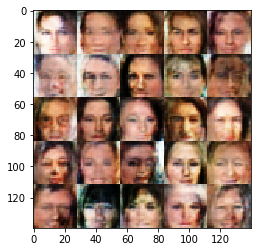

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.7748
iteration 1300


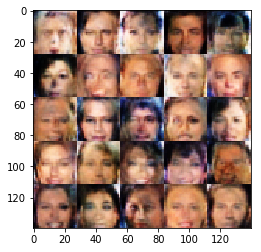

Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7768
iteration 1400


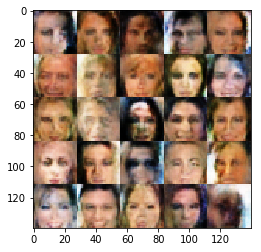

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7711
iteration 1500


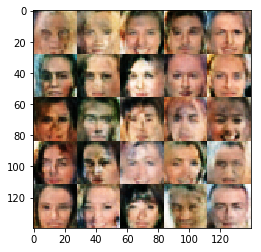

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7380
Training done seconds: 467.28142523765564. Time in minutes: 7.788023753960927


In [90]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.